In [48]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import plotly_express as px
import networkx as nx
import osmnx as ox

In [49]:
ox.config(use_cache=True, log_console=True)

2021-09-24 09:51:29 Configured OSMnx 1.1.1
2021-09-24 09:51:29 HTTP response caching is on


In [50]:
def create_graph(loc, dist, transport_mode, loc_type="address"):
    """Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’"""
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
    return G

2021-09-24 09:51:30 Retrieved response from cache file "cache/122893a9c77ace471118d977e4561a9f45117fb9.json"
2021-09-24 09:51:30 Geocoded "Rochester" to (43.157285, -77.615214)
2021-09-24 09:51:30 Created bbox 2500 m from (43.157285, -77.615214): 43.17976800838733,43.134801991612676,-77.58439335186361,-77.64603464813638
2021-09-24 09:51:30 Projected GeoDataFrame to +proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2021-09-24 09:51:30 Projected GeoDataFrame to epsg:4326
2021-09-24 09:51:30 Projected GeoDataFrame to +proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2021-09-24 09:51:30 Projected GeoDataFrame to epsg:4326
2021-09-24 09:51:30 Requesting data within polygon from API in 1 request(s)
2021-09-24 09:51:30 Retrieved response from cache file "cache/65fbc30c508cea0bd9b4c3eda84865c3ad760432.json"
2021-09-24 09:51:30 Got all network data within polygon from API in 1 request(s)
2021-09-24 09:51:30 Creating graph from downloaded OSM data...

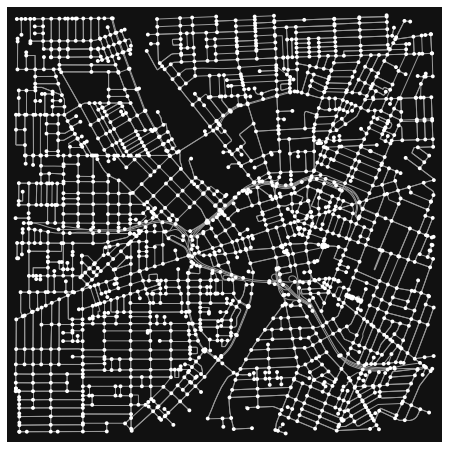

2021-09-24 09:51:35 Finished plotting the graph


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [51]:
G = create_graph('Rochester', 2500, 'drive')
ox.plot_graph(G)

2021-09-24 09:51:35 Created edges GeoDataFrame from graph
2021-09-24 09:51:35 Created edges GeoDataFrame from graph
2021-09-24 09:51:35 Created nodes GeoDataFrame from graph
2021-09-24 09:51:35 Created nodes GeoDataFrame from graph
2021-09-24 09:51:35 Begin plotting the graph...


/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning:

The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning:

The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.



2021-09-24 09:51:35 Created edges GeoDataFrame from graph
2021-09-24 09:51:36 Finished plotting the graph


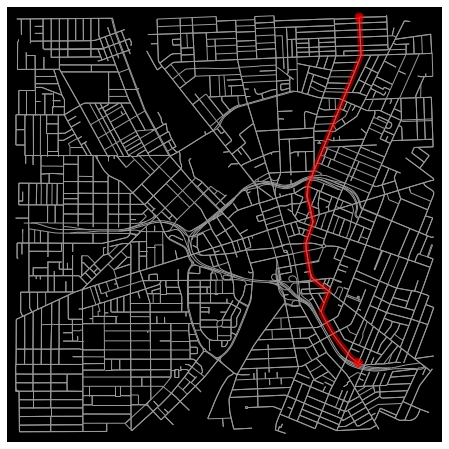

In [52]:
G = ox.add_edge_speeds(G) #Impute
G = ox.add_edge_travel_times(G) #Travel time
start = (43.14277, -77.59541)
end = (43.22447, -77.59820)
start_node = ox.get_nearest_node(G, start)
end_node = ox.get_nearest_node(G, end)
# Calculate the shortest path
route = nx.shortest_path(G, start_node, end_node, weight='travel_time')
#Plot the route and street networks
ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k');

In [53]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []
for u, v in zip(route[:-1], route[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [54]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from, X_to, Y_to, length, travel_time)),
columns =['node_start', 'node_end', 'X_from', 'Y_from', 'X_to', 'Y_to', 'length', 'travel_time'])
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,212711088,212711081,-77.595508,43.142408,-77.597028,43.143370,164,12
1,212711081,212711079,-77.597028,43.143370,-77.599238,43.145524,299,22
2,212711079,212627933,-77.599238,43.145524,-77.600190,43.146721,154,12
3,212627933,3665094176,-77.600190,43.146721,-77.600941,43.147955,152,11
4,3665094176,212890741,-77.600941,43.147955,-77.600548,43.148808,100,8


In [55]:
def create_line_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
    gdf['geometry_to'] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
    gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
    line_gdf = gdf[['node_start','node_end','length','travel_time', 'line']].set_geometry('line')
    return line_gdf
line_gdf = create_line_gdf(df)

In [56]:
start = df[df['node_start'] == start_node]
end = df[df['node_end'] == end_node]

In [57]:
px.scatter_mapbox(df, lon= 'X_from', lat='Y_from', zoom=12)

In [58]:
fig = px.scatter_mapbox(df, lon= 'X_from', lat='Y_from', zoom=13, width=1000, height=800, animation_frame=df.index,mapbox_style='dark')
fig.data[0].marker = dict(size = 12, color='black')
fig.add_trace(px.scatter_mapbox(start, lon= 'X_from', lat='Y_from').data[0])
fig.data[1].marker = dict(size = 15, color='red')
fig.add_trace(px.scatter_mapbox(end, lon= 'X_from', lat='Y_from').data[0])
fig.data[2].marker = dict(size = 15, color='green')
fig.add_trace(px.line_mapbox(df, lon= 'X_from', lat='Y_from').data[0])
fig